# Tietjen-Moore Test for Outliers
The <i>Tietjen-Moore Test</i> is a test to determine if there are <b>exactly</b> $\boldsymbol k$ outliers in data that is approximately normally distributed. <br>
The Tietjen-Moore test for $k=1$ outliers is called the <i>Grubbs Test</i> <br>
For $X = (x_1, ..., x_n)$ and $Z = (z_1, ..., z_n)$ such that $z_i = x_j$ such that $x_j$ is the $i^{th}$ furthest point in $X$ from the sample mean.
\begin{equation*}
U_k = \frac{\sum_{i=1}^{n-k} (z_i - \bar z_k)^2}{\sum_{i=1}^n (x - \bar x)^2}
\end{equation*}


In [1]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import cupy as cp
import numpy as np
import sqlite3

In [2]:
def TienjenStatistic(x: np.ndarray, kRange):
    mean = x.mean()
    r = np.abs(x - mean)
    z = x[r.argsort()]
    z = cp.array(z)
    total = None
    denom = ((z - z.mean()) ** 2).sum()
    if denom != 0:
        E = []
        progressBar = tqdm(kRange)
        for k in progressBar:
            if total is None:
                total = z[:-(k + 1)].sum()
            total += z[-(k + 1)]
            mean = total / (len(z) - k)
            E.append(cp.sum((z[:-k] - mean) ** 2) / denom)
        del z, total, denom, k, mean

        npE = cp.asnumpy(cp.array(E))
    else:
        npE = np.zeros(len(kRange))

    return npE


In [3]:
count = 1000000 # Approximately the number of rows in the combined normal and attack data

Make a graph of random normally distributed Tietjen Statistics to compare to.

In [4]:
normalRandom = np.random.normal(size=count)
kRange = list(range(1, 100000))
e_norm = TienjenStatistic(normalRandom, kRange)

  0%|          | 0/99999 [00:00<?, ?it/s]

In [5]:
def plotData(data: list, names: list, alpha: float, kwargLists=None, plotTitle=None):
    """
    :param data: List of data arrays to plot
    :param names: List of names for each array
    :param alpha: significance level to plot
    :param kwargLists: dict with lists of any values that you want to set (optional)
    :param plotTitle: The title of the plot (optional)
    """
    plt.figure(figsize=(10, 10))

    if kwargLists is None:
        kwargLists = {'y': data, 'label': names}
    else:
        kwargLists['y'] = data
        kwargLists['label'] = names

    gen = [dict(zip(kwargLists, vals)) for vals in zip(*(kwargLists[key] for key in kwargLists))]  # magic
    for values in gen:
        kwargs = values
        plt.scatter(kRange[:len(kwargs['y'])], **kwargs)

    # Plot Critical Boundary
    criticalCuttoff = np.percentile(e_norm, alpha * 100)
    plt.scatter(kRange, np.ones_like(kRange) * criticalCuttoff, label=f'$\\alpha={alpha}$', color='green')

    # Plot Vertical line at True number of attack data points
    # True number of attack data points: 54854
    plt.axvline(x=54854, color='red', label='True number of anomalies')

    if plotTitle is not None:
        plt.title(plotTitle)
    plt.legend(loc='upper right')
    plt.xlabel('$K$')
    plt.ylabel('$U_k$')

    # plt.show()

A Tietjen-Moore statistic below the critical line means to reject the null hypothesis.

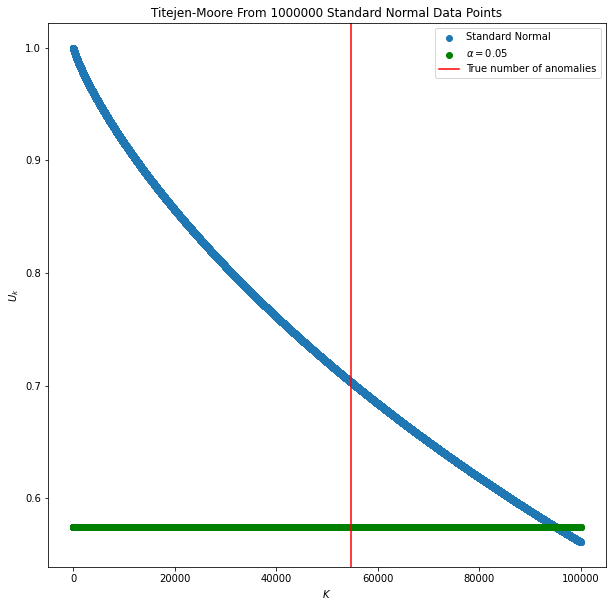

In [6]:
plotData([e_norm], ['Standard Normal'], 0.05, plotTitle=f'Titejen-Moore From {count} Standard Normal Data Points')

In [7]:
con = sqlite3.connect("Tietjen.db")
cursor = con.cursor()

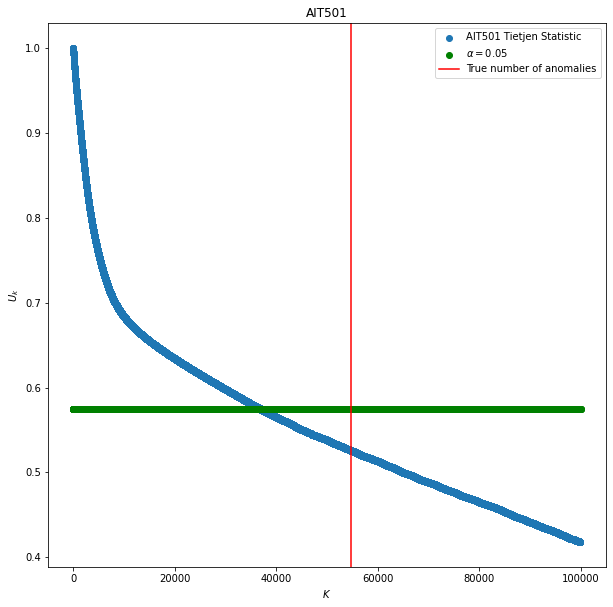

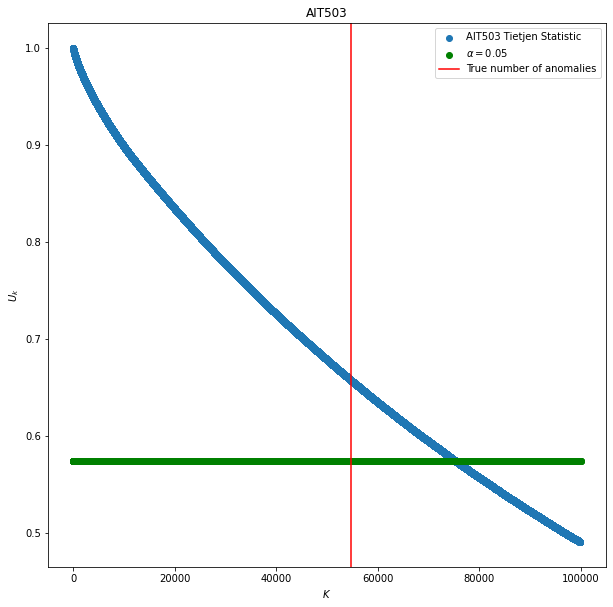

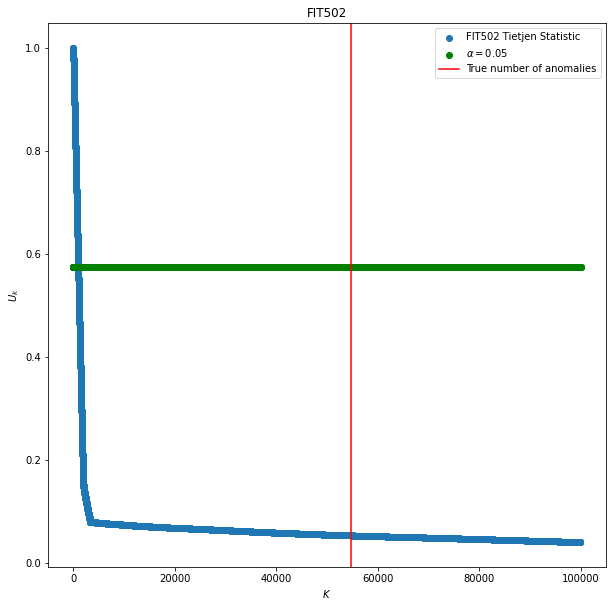

In [8]:
# Plot the graphs
for col in 'AIT501, AIT503, FIT502'.split(', '):
    try:
        result = np.array(list(cursor.execute(f"""SELECT K, VALUE FROM Tietjen_Statistics WHERE COL='{col}' ORDER BY K ASC""")))
    except:
        continue
    plotData([result[:, 1]], [col + " Tietjen Statistic"], 0.05)
    plt.title(col)

    plt.show()